# Lane Fitting for the ONNX lane detection model output

2024-02-12 09:26:16.619890 [W:onnxruntime:, coreml_execution_provider.cc:81 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 24 number of nodes in the graph: 326 number of nodes supported by CoreML: 299


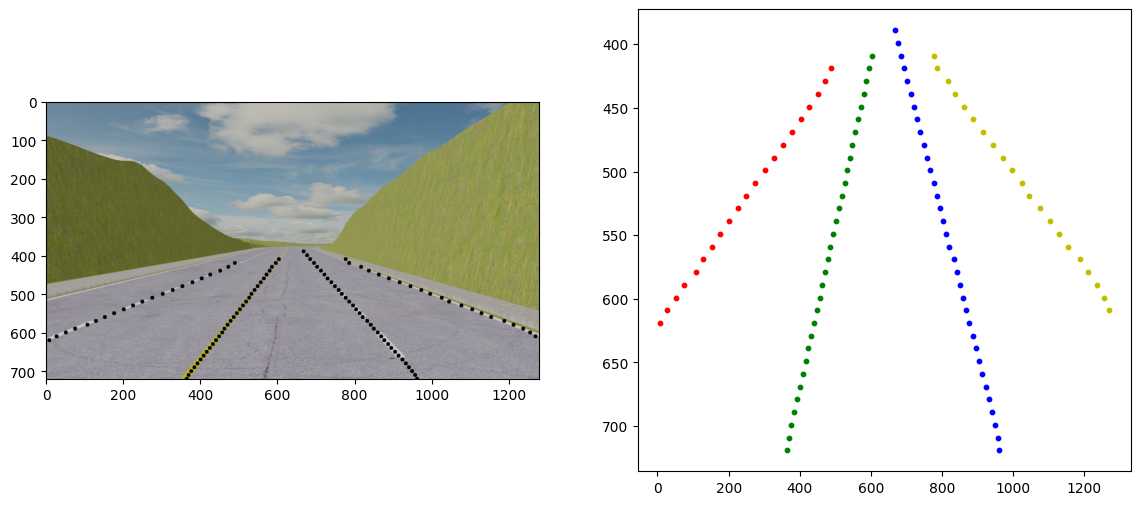

In [11]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import cv2
import numpy as np
from matplotlib import pyplot as plt
from inference_file import inference
import pytorch_auto_drive.functional as F

FILENAME = 'example_input.jpg'
# results, keypoints = inference(FILENAME, model_path='../../resnet50_resa_tusimple_20211019.onnx')
results, keypoints = inference(FILENAME, model_path='../../resnet50_resa_culane_20211016.onnx')

infered_img = results[0]
keypoints = keypoints[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.imshow(infered_img)
ax2.invert_yaxis()

colors = ['r', 'g', 'b', 'y', 'c', 'm']
for i, lane in enumerate(keypoints):
    for point in lane:
        ax2.scatter(point[0], point[1], s=10, c=colors[i], marker='o')



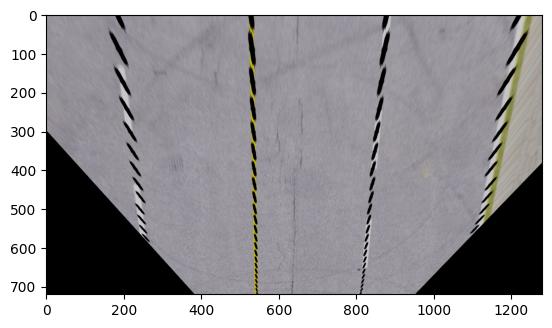

In [12]:
def getTransformMatrix(inpImage):
    # manually selected source and destination points
    src =  np.float32([[480, 500], [800, 500], [inpImage.shape[1]-50, inpImage.shape[0]],  [150, inpImage.shape[0]]])
    line_dst_offset = 300

    dst = np.float32([[src[3][0] + line_dst_offset, 0], \
          [src[2][0] - line_dst_offset, 0], \
          [src[2][0] - line_dst_offset, src[2][1]], \
          [src[3][0] + line_dst_offset, src[3][1]]])

    matrix = cv2.getPerspectiveTransform(src, dst)
    minv = cv2.getPerspectiveTransform(dst, src)
    return matrix, minv

def perspectiveWarpImage(inpImage):
    matrix, matrix_inv = getTransformMatrix(inpImage)
   
    birdseye = cv2.warpPerspective(inpImage, matrix, inpImage.shape[0:2][::-1])

    # Get the birdseye window dimensions
    height, width = birdseye.shape[:2]

    # Divide the birdseye view into 2 halves to separate left & right lanes
    birdseyeLeft  = birdseye[0:height, 0:width // 2]
    birdseyeRight = birdseye[0:height, width // 2:width]

    # Display birdseye view image
    plt.imshow(birdseye)

perspectiveWarpImage(infered_img)

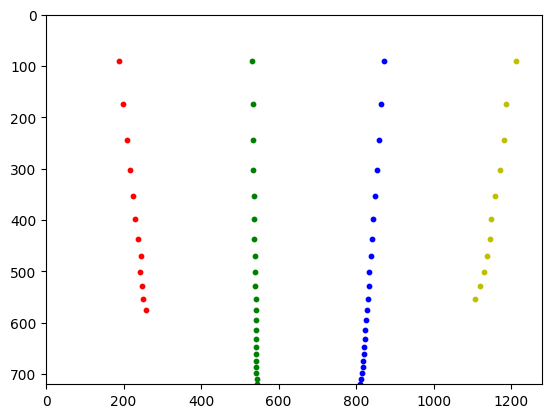

In [3]:
def perspectiveWarp(keypoints, inpImage):

    colors = ['r', 'g', 'b', 'y', 'c', 'm']

    lanes=[]
    for i, lane in enumerate(keypoints): 
        matrix, matrix_inv = getTransformMatrix(inpImage)

        plt.ylim([0,inpImage.shape[0]])
        plt.xlim([0,inpImage.shape[1]])        
        plt.gca().invert_yaxis()

        result_points = []
        for point in lane:
            # https://stackoverflow.com/a/57400980
            px = (matrix[0][0]*point[0] + matrix[0][1]*point[1] + matrix[0][2]) / ((matrix[2][0]*point[0] + matrix[2][1]*point[1] + matrix[2][2]))
            py = (matrix[1][0]*point[0] + matrix[1][1]*point[1] + matrix[1][2]) / ((matrix[2][0]*point[0] + matrix[2][1]*point[1] + matrix[2][2]))
            point = (px, py)
            result_points.append(point)
            plt.scatter(point[0], point[1], s=10, c=colors[i], marker='o')

        
        lanes.append(np.float32(result_points))
        
    return lanes
        
plt.show()
lanes = perspectiveWarp(keypoints, infered_img)

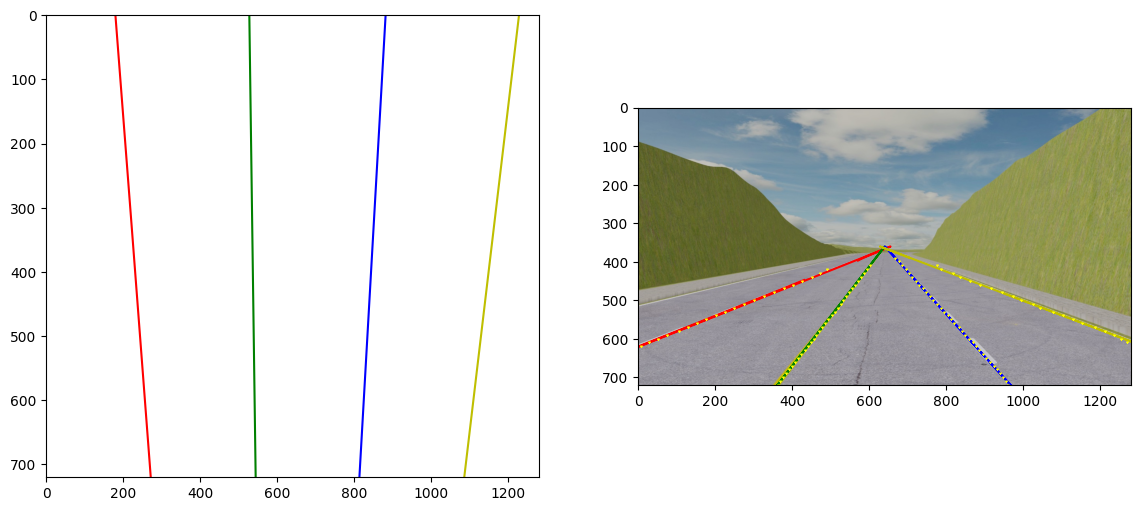

In [4]:
# Lane fitting

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.set_xlim([0,infered_img.shape[1]])
ax1.set_ylim([0,infered_img.shape[0]])
ax1.invert_yaxis()
colors = ['r', 'g', 'b', 'y', 'c', 'm']
matrix, matrix_inv = getTransformMatrix(infered_img)

lanes_transformed = []

for i, lane in enumerate(lanes): 
    polynom = np.polyfit(lane[:,0], lane[:,1], 2)
    predict = np.poly1d(polynom)
    x_lin_reg = range(0, infered_img.shape[1])
    y_lin_reg = predict(x_lin_reg)
    ax1.invert_yaxis()
    ax1.plot(x_lin_reg, y_lin_reg, c = colors[i])

    lane_points_transformed=[[],[]]
    for point in x_lin_reg:
        point = (point, predict(point))
        px = (matrix_inv[0][0]*point[0] + matrix_inv[0][1]*point[1] + matrix_inv[0][2]) / ((matrix_inv[2][0]*point[0] + matrix_inv[2][1]*point[1] + matrix_inv[2][2]))
        py = (matrix_inv[1][0]*point[0] + matrix_inv[1][1]*point[1] + matrix_inv[1][2]) / ((matrix_inv[2][0]*point[0] + matrix_inv[2][1]*point[1] + matrix_inv[2][2]))
        p = (px, py)
        # TODO: check this limit
        if py > infered_img.shape[0] / 2:
            lane_points_transformed[0].append(px)  
            lane_points_transformed[1].append(py)
    # plt.scatter(lane_points_transformed[0], lane_points_transformed[1], s=10, c=colors[i], marker='o')
    lanes_transformed.append(lane_points_transformed)

from PIL import Image
# overlay the original image
original_img = Image.open(FILENAME)
for i, lane in enumerate(lanes_transformed):
    ax2.plot(lane[0], lane[1], c = colors[i], zorder=1)
# ax2.fill_betweenx(lanes_transformed[1][1], lanes_transformed[1][0], lanes_transformed[2][0])
# print initial keypoints
for lane in keypoints:
    for point in lane:
        ax2.scatter(point[0], point[1], marker="2", color="yellow", s=2, zorder=2)
ax2.imshow(original_img)




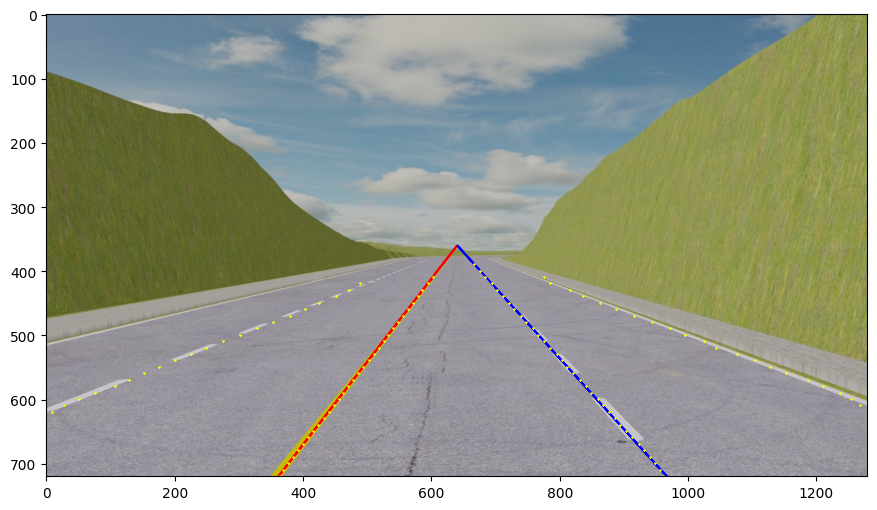

In [13]:
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))


left_lane = np.float32(lanes_transformed[0])
right_lane = np.float32(lanes_transformed[len(lanes_transformed)-1])
selected_indices = [0, len(lanes_transformed)-1]
middle = original_img.size[0]/2

for i, lane in enumerate(lanes_transformed):
    avg = np.average(lane[0])

    if avg < middle and avg > np.average(left_lane[0]):
        left_lane = np.float32(lane)
        selected_indices[0] = i
        continue

    if avg > middle and avg < np.average(right_lane[0]):
        right_lane = np.float32(lane)
        selected_indices[1] = i
        continue

    
left_lane = left_lane.T
left_lane = np.vstack(left_lane[left_lane[:, 0] <= middle, :]).T

right_lane = right_lane.T
right_lane = np.vstack(right_lane[right_lane[:, 0] >= middle, :]).T

ax1.plot(left_lane[0], left_lane[1], c = 'red', zorder=1)
ax1.plot(right_lane[0], right_lane[1], c = 'blue', zorder=1)

for lane in keypoints:
    for point in lane:
        ax1.scatter(point[0], point[1], marker="2", color="yellow", s=2, zorder=2)
ax1.imshow(original_img)

# TODO: get the curves in the original image perspective
